## Using `sklearn`'s Classifiers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import ast

tracks = utils.load_csv("tracks")
genres = utils.load_csv("genre")
features = utils.load_csv("features")

fma_small_ids = tracks.index
features = features.loc[fma_small_ids]


### Preprocessing
* Scale the features such that they have a mean of 0 and variance of 1
* Encode the output

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

genre_title_to_id = dict(zip(genres.title, genres.index))
tracks["track", "genre_id"] = [genre_title_to_id[title] for title in tracks["track", "genre_top"]]

scaler = StandardScaler().fit(features)
scaled_features = scaler.transform(features)

enc = LabelEncoder()
encoded_genre_ids = enc.fit_transform(tracks["track", "genre_id"])

all_ids = tracks.index
ids_by_type = [tracks[tracks["set", "split"] == type].index for type in ["training", "validation", "test"]]
train_ids, validate_ids, test_ids = ids_by_type
idxs_by_type = [[tracks.index.get_loc(id) for id in ids] for ids in ids_by_type]
train_idxs, validate_idxs, test_idxs = idxs_by_type

X_train, X_validate, X_test = [scaled_features[idxs] for idxs in idxs_by_type]
y_train, y_validate, y_test = [encoded_genre_ids[idxs] for idxs in idxs_by_type]

y_test_binarize = label_binarize(y_test, classes=range(len(enc.classes_)))

### Visualising the features data
* Below is t-SNE plot obtained by embedding the >500 features into 2 dimensions.
* VIsually, there are some clear clusters that can be seen in the plot. For example, there is a clear green (Rock) cluster nearer to the top of the plot, whilst the right side of the plot contains more red (Electronic) points.
* However, there are also some genres which do not show a clear single cluster, for example the Folk, Instrumental and International genres.

In [3]:
from sklearn.manifold import TSNE

embedded_features = TSNE(n_components=2).fit_transform(scaled_features)

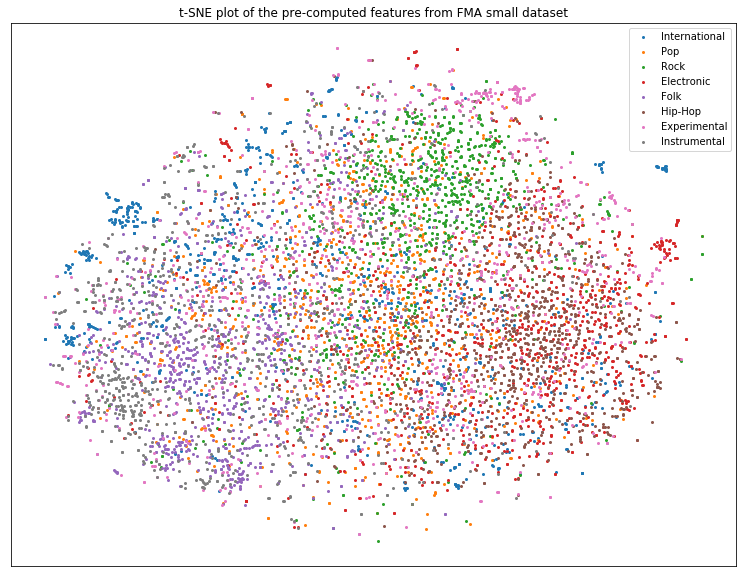

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(13, 10))
genre_ids = tracks["track", "genre_id"]

for genre_id in enc.classes_:
    idxs = [i for i, id in enumerate(genre_ids) if id == genre_id]
    axs.scatter(embedded_features[idxs, 0], embedded_features[idxs, 1], label=genres.loc[genre_id]["title"], s=4)
    axs.set_title("t-SNE plot of the pre-computed features from FMA small dataset")
    axs.set_xticks([])
    axs.set_yticks([])

axs.legend()

### Classifying Genre 
* Classifiers then can be used:
    * linear_model - LogisticRegression, RidgeClassifierCV
    * svm - LinearSVC, SVC
    * ensemble - RandomForestClassifier, AdaBoostClassfier, GradientBoostingClassifier
    * naive_bayes - GaussianNB
    * discriminant_analysis - LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
    * multiclass - OneVsRestClassifier
    * neighbors - KNeighborsClassifier
    * neural_network - MLPClassifier
* Attempted to use `GridSearchCV` to search for better parameters for the classifiers. However, found that the accuracy remained in regions +-0.03 of its original value.
* The scores and ROC curves below show that SVM, LDA and MLP classifiers work well here
* Note that the accuracy score here is a valid metric to determine the success of the classifier, since the distribution across all genres are balanced. Note that the score of >0.5 already shows that there are features that does correlate with genre, given that a null hypothesis would give a score of 0.125 (1/8) since there are 8 genres.
* Obtaining the feature importances of the RandomForestClassifier shows relatively equal importances across all features


In [11]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm
import time

classifiers = {
    "LR": LogisticRegression(), "RC": RidgeClassifier(),
    "LSVM": LinearSVC(),
    "SVM": SVC(),
    "RFC": RandomForestClassifier(), "ABC": AdaBoostClassifier(),
    "GNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(), "QDA": QuadraticDiscriminantAnalysis(),
    "OvRC": OneVsRestClassifier(LogisticRegression()),
    "KNC": KNeighborsClassifier(),
    "MLP": MLPClassifier()
}

for name, clf in classifiers.items():
    start = time.time()
    print(f"\n ****** CLASSIFYING {name} ******")
    clf.fit(X_train, y_train)
    end = time.time()
    print(f"TIME TAKEN: {int((end - start) / 60)} min {round((end - start) % 60, 2)} s")


 ****** CLASSIFYING LR ******
TIME TAKEN: 0 min 1.02 s

 ****** CLASSIFYING RC ******
TIME TAKEN: 0 min 0.07 s

 ****** CLASSIFYING LSVM ******
TIME TAKEN: 0 min 56.01 s

 ****** CLASSIFYING SVM ******
TIME TAKEN: 0 min 36.31 s

 ****** CLASSIFYING RFC ******
TIME TAKEN: 0 min 12.0 s

 ****** CLASSIFYING ABC ******
TIME TAKEN: 0 min 22.58 s

 ****** CLASSIFYING GNB ******
TIME TAKEN: 0 min 0.04 s

 ****** CLASSIFYING LDA ******
TIME TAKEN: 0 min 0.74 s

 ****** CLASSIFYING QDA ******
TIME TAKEN: 0 min 0.78 s

 ****** CLASSIFYING OvRC ******
TIME TAKEN: 0 min 3.02 s

 ****** CLASSIFYING KNC ******
TIME TAKEN: 0 min 0.4 s

 ****** CLASSIFYING MLP ******
TIME TAKEN: 0 min 11.18 s


In [12]:
import numpy as np

n_genres = len(enc.classes_)
score = dict()
fpr = dict()
tpr = dict()
confusion_mats = dict() 

for name, clf in classifiers.items():
    score[name] = clf.score(X_test, y_test)
    fpr[name] = dict()
    tpr[name] = dict()
    confusion_mats[name] = np.zeros((n_genres, n_genres))

    for i, genre_id in enumerate(enc.classes_):
        if name in ["LSVM", "SVM", "RC"]:
            y_proba = classifiers[name].decision_function(X_test)
        else:
            y_proba = classifiers[name].predict_proba(X_test)
        fpr[name][i], tpr[name][i], _ = metrics.roc_curve(y_test_binarize[:, i], y_proba[:, i])

        y_predict = y_proba.argmax(axis=1)
        genre_idxs = np.where(y_test == i)[0]
        confusion_row_i = np.array([(y_predict[genre_idxs] == n).sum() for n in range(n_genres)])
        confusion_mats[name][i] = confusion_row_i

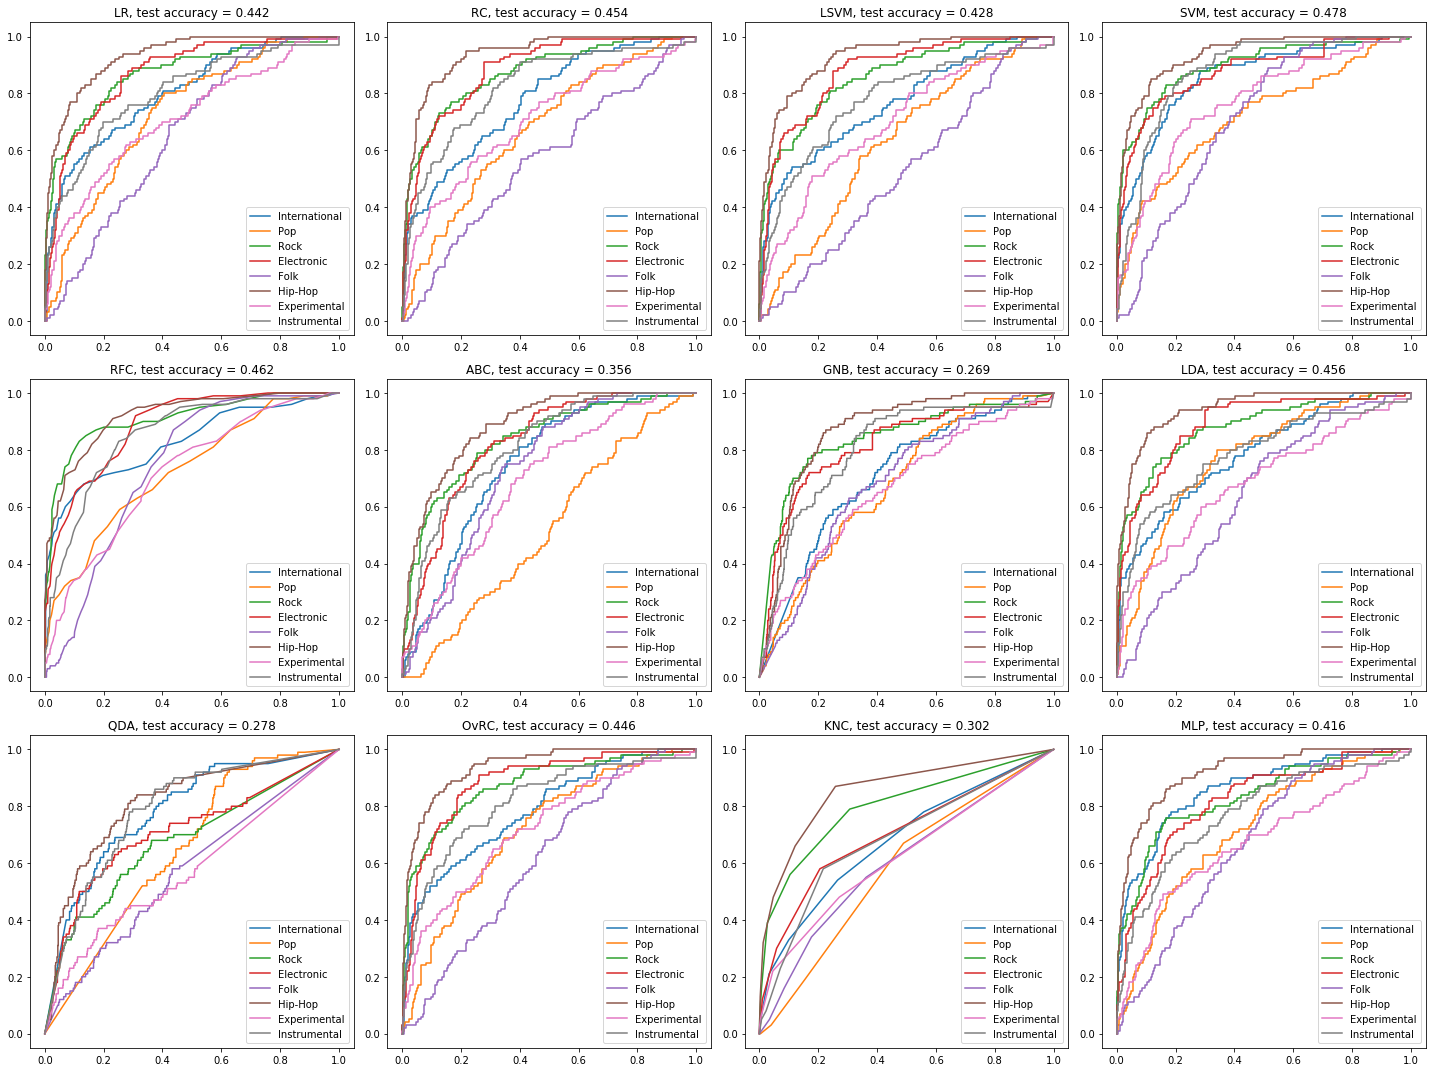

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for idx, (name, clf) in enumerate(classifiers.items()):
    for i, genre_id in enumerate(enc.classes_):
        axs[int(idx / 4)][idx % 4].plot(fpr[name][i], tpr[name][i], label=genres.loc[genre_id]["title"])
    
    axs[int(idx / 4)][idx % 4].set_title(f"{name}, test accuracy = {round(score[name], 3)}")
    axs[int(idx / 4)][idx % 4].legend()
fig.tight_layout()

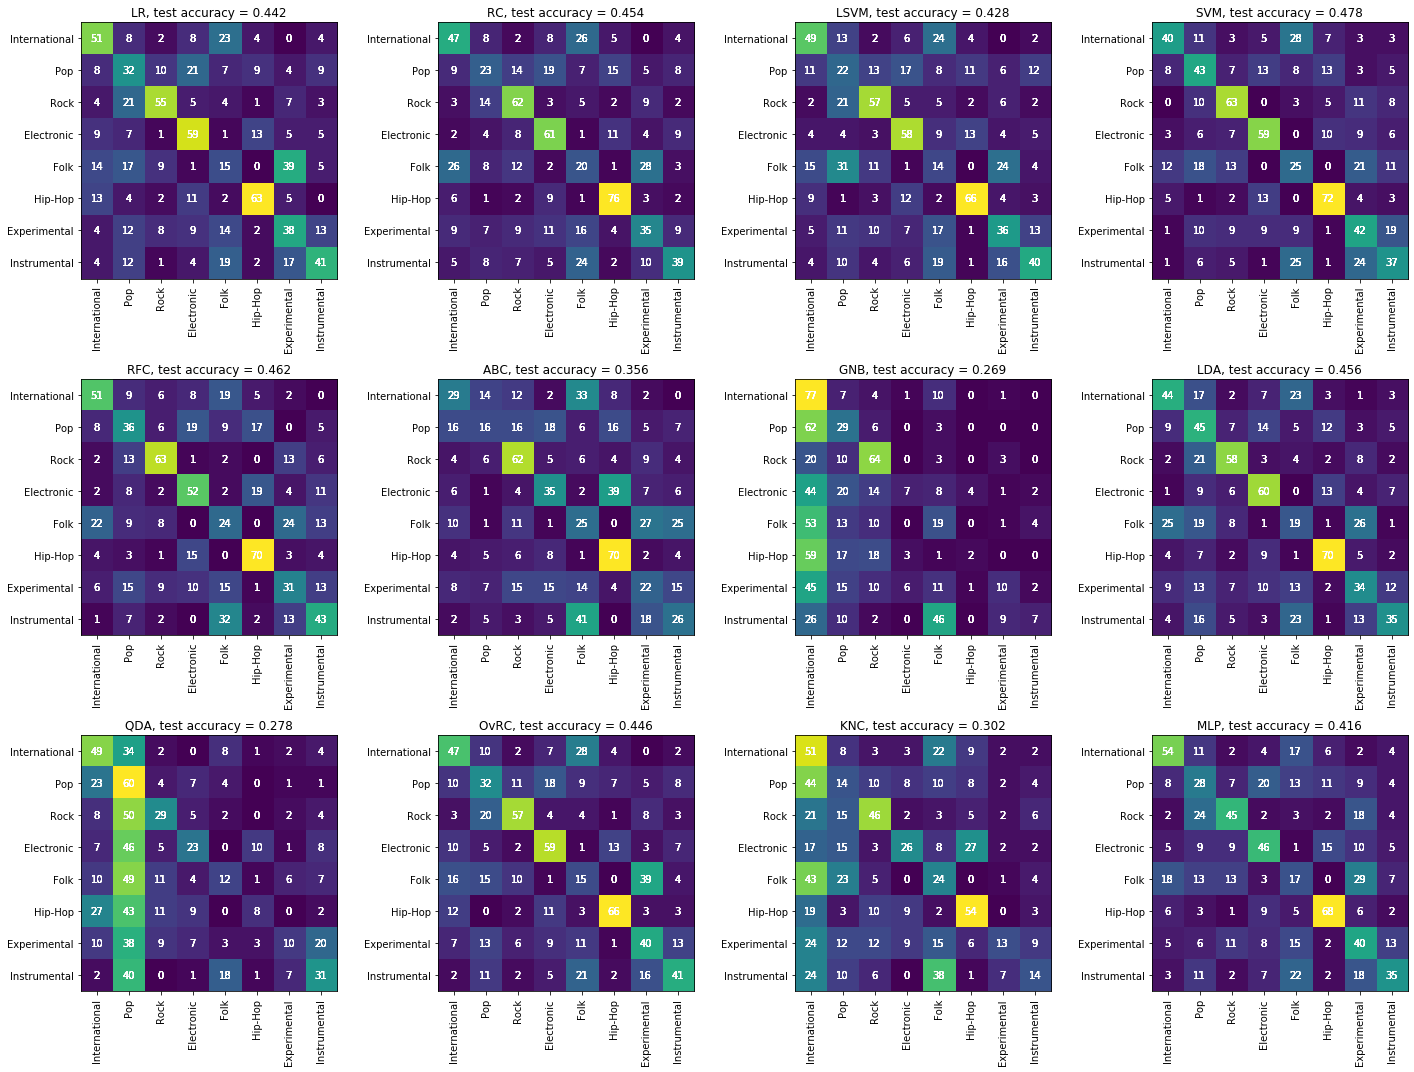

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
n_genres = len(enc.classes_)
relevant_genres = genres.loc[enc.classes_]["title"].tolist()

for idx, (name, clf) in enumerate(classifiers.items()):
    curr_axs = axs[int(idx / 4)][idx % 4] 
    for i, genre_id in enumerate(enc.classes_):
        curr_axs.imshow(confusion_mats[name])

        curr_axs.set_xticks(np.arange(n_genres))
        curr_axs.set_xticklabels(labels=relevant_genres, rotation="vertical")
        curr_axs.set_yticks(np.arange(n_genres))
        curr_axs.set_yticklabels(labels=relevant_genres)
        for i in range(n_genres):
            for j in range(n_genres):
                curr_axs.text(j, i, int(confusion_mats[name][i][j]), va="center", ha="center", color='w')

    curr_axs.set_title(f"{name}, test accuracy = {round(score[name], 3)}")
fig.tight_layout()